# Centroid Vetting Example

Transit-like signals can be created when unresolved eclipsing binaries and other variable sources are present on the detector. One method of determining whether the transit signal was from the target or the background is by measuring the centroid of the light. If the centroid is not on the target there is a likelihood of the transit being a False Positive (Kostov et al. 2019, apj 157:124 section 2.1). 

Exovetter.Centroid returns the average offset and significance that it is on the target. You get several plots showing the out of transits, in transit and difference image. The centroids of each are measured using a Gaussian. For the OOT and In-Transit, the centroid is constrained to the central +/-1pixel in box row and column direction. 

In [1]:
from exovetter.tce import Tce
from exovetter import vetters as vet
from exovetter import const as exo_const
from exovetter import utils
import lightkurve as lk
from astropy import units as u
import matplotlib.pyplot as plt
%matplotlib inline

## Setup and Vetting
Exovetter vetting alogrithms usually use TCE and lightkurve objects as input. The Centroid Vetter however requires a Target Pixel File objects from lightkurve. Here we will show two examples, one with no offset and another with a small but possible offset.

In [2]:
# TCE with a negligible offset (the known planet WASP-18 b we have used in the other notebooks)

period = 0.94145223 * u.day
epoch = 1354.4579 * u.day
epoch_offset = exo_const.btjd
depth = 0.00931894 * exo_const.frac_amp
duration = 0.08932 * u.day

tce = Tce(period=period, epoch=epoch, epoch_offset=epoch_offset, 
          depth=depth, duration=duration, comment='example')

# Download the relevent target pixel file for this tce
tpf = lk.search_targetpixelfile('WASP-18 b', author='SPOC')[0].download()


# run the centroid vetter with this tce and tpf
centroid_instance = vet.Centroid()
centroid_results = centroid_instance.run(tce, tpf)
centroid_results

{'offset': 0.07074984782477667, 'significance': array([0.95712504])}

In [3]:
# TCE with a possible offset
candidate = "TOI 565.01"
tce = utils.get_mast_tce(candidate)[0]

# Download the relevent target pixel file for this tce
tpf = lk.search_targetpixelfile(candidate)[0].download()

# run the centroid vetter with this tce and tpf
centroid_instance = vet.Centroid()
centroid_results = centroid_instance.run(tce, tpf)
centroid_results

{'offset': 1.280240445042257, 'significance': array([9.57840576e-206])}

In Centroid, the results are as follows:
* offset : Size of offset in pixels (or whatever unit centroids is in)
* significance : The statistical significance of the transit. Values close to 1 mean the transit is likely on the target star. Values less than ~1e-3 suggest the target is not the source of the transit.
           

The following attributes are also available after running the vetter object:
* metrics : Centroid result dictionary.
* tpf : The target pixel file used for the centroid calculations

## Plots
In order to generate diagnostic plots from vetters, we use the `plot` method with the vetter object after it has been run. We will generate the diagnostic plot here for the TCE and TPF that have a centroid offset.

<Figure size 640x480 with 0 Axes>

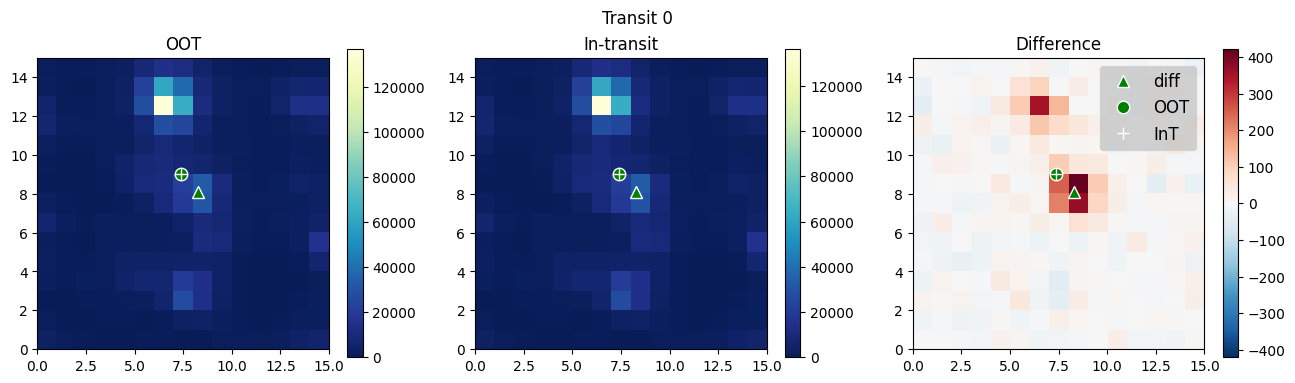

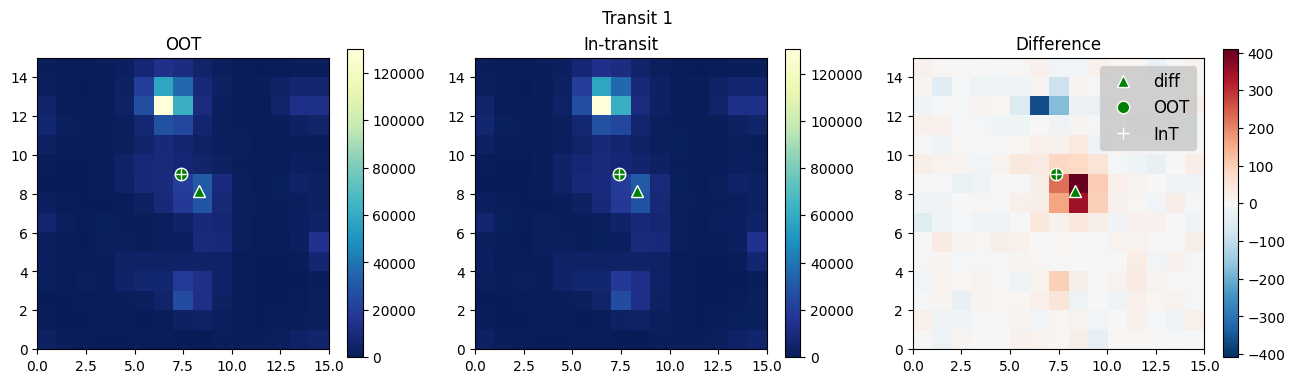

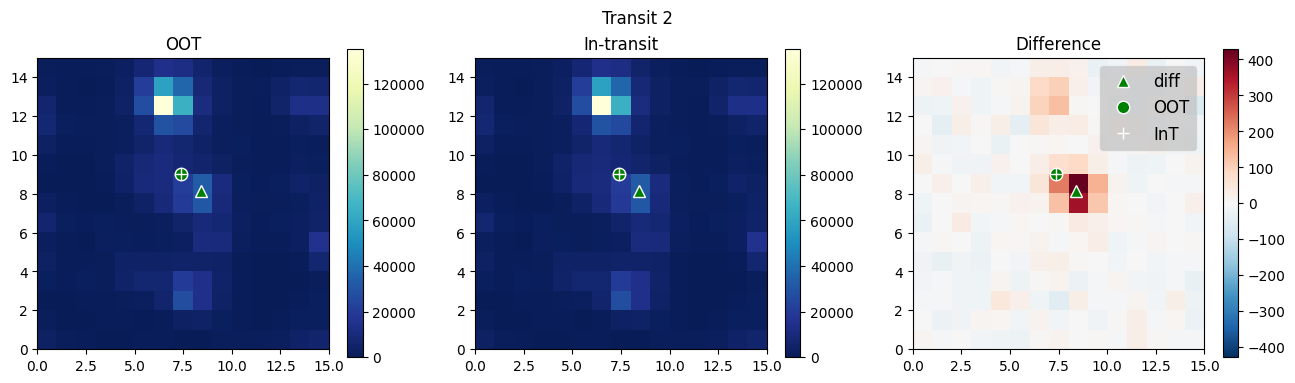

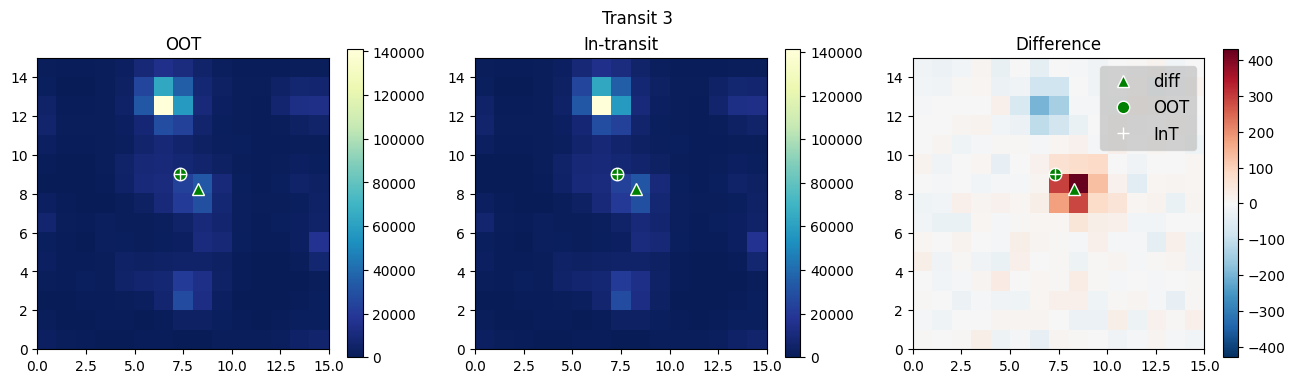

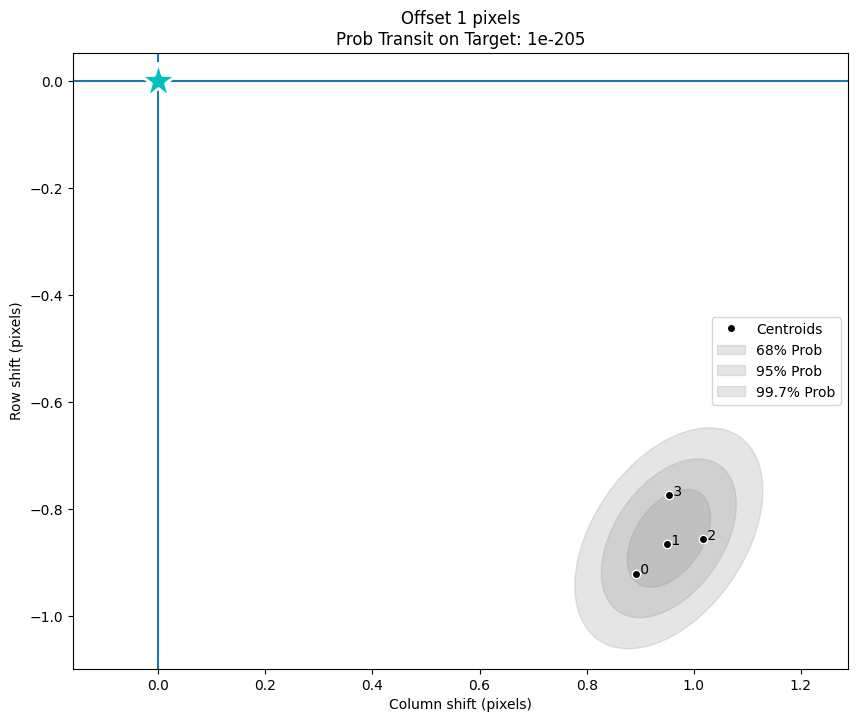

In [4]:
plt.figure()
centroid_instance.plot()
plt.show()

## Additional options
Centroid also has the option to place the pixel coordinates of a desired target star on the tpf image. The resulting difference will be taken from the target star rather than the fit of the out of transit centroid.

{'offset': 0.7528639208530379, 'significance': array([5.6553974e-37])}

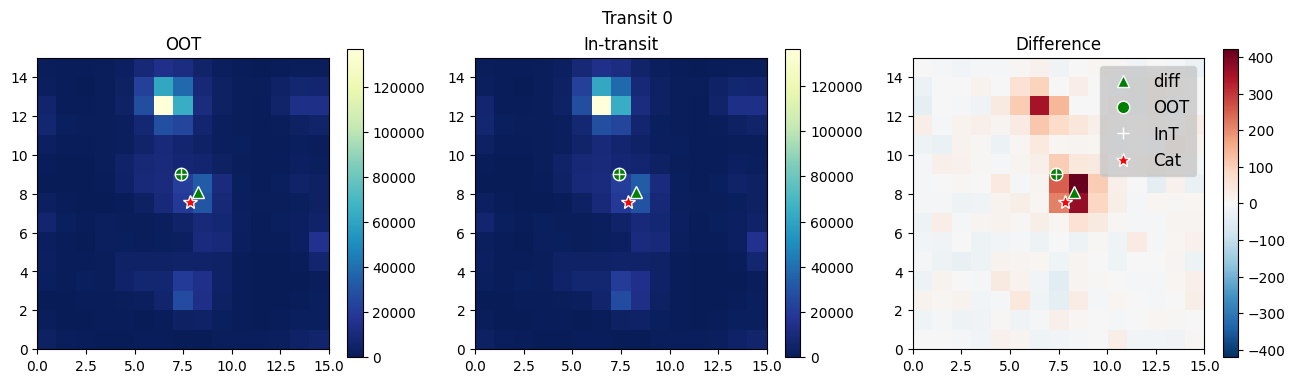

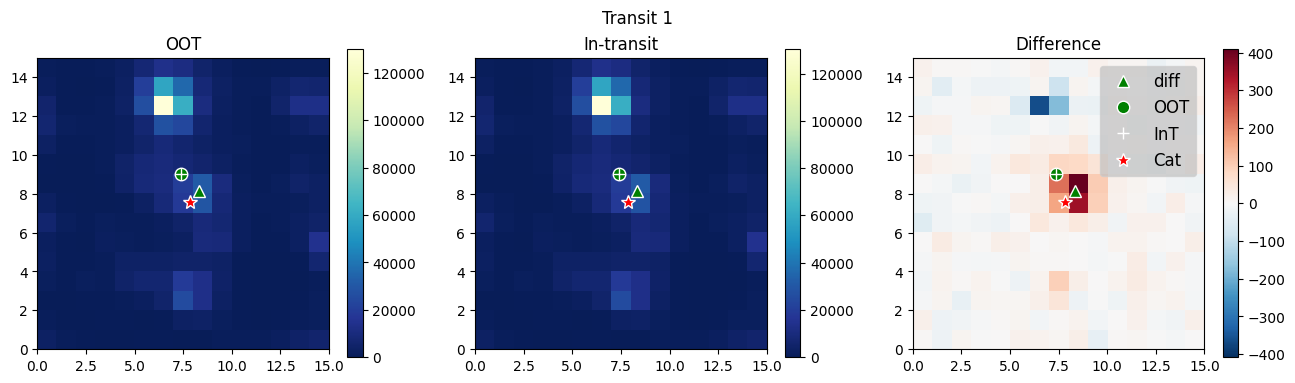

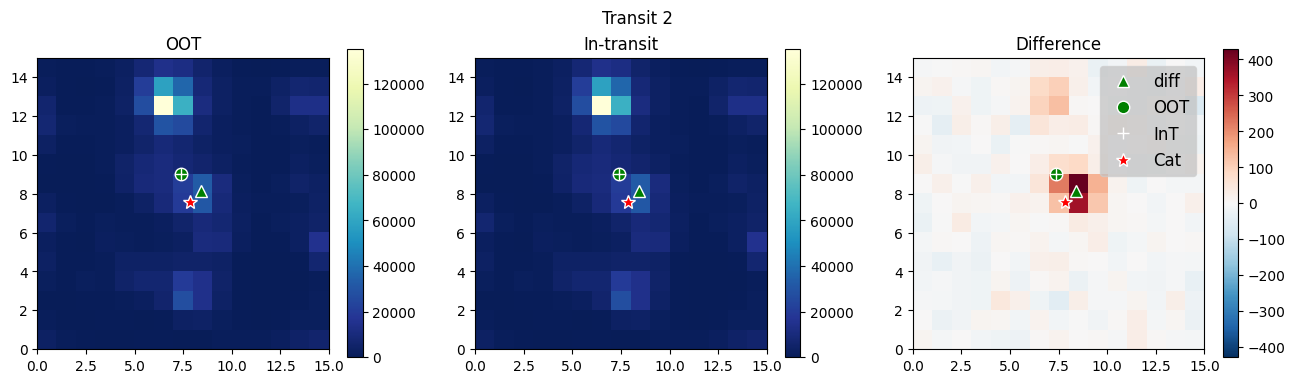

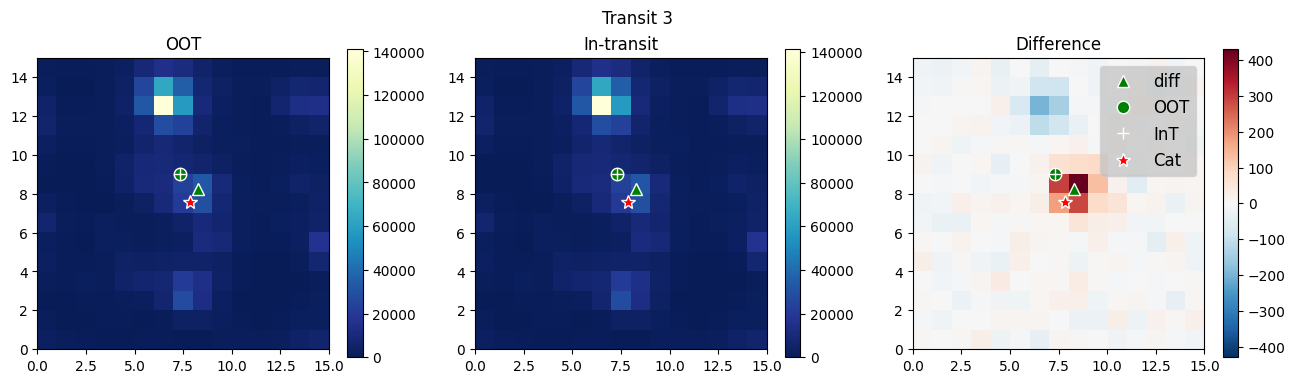

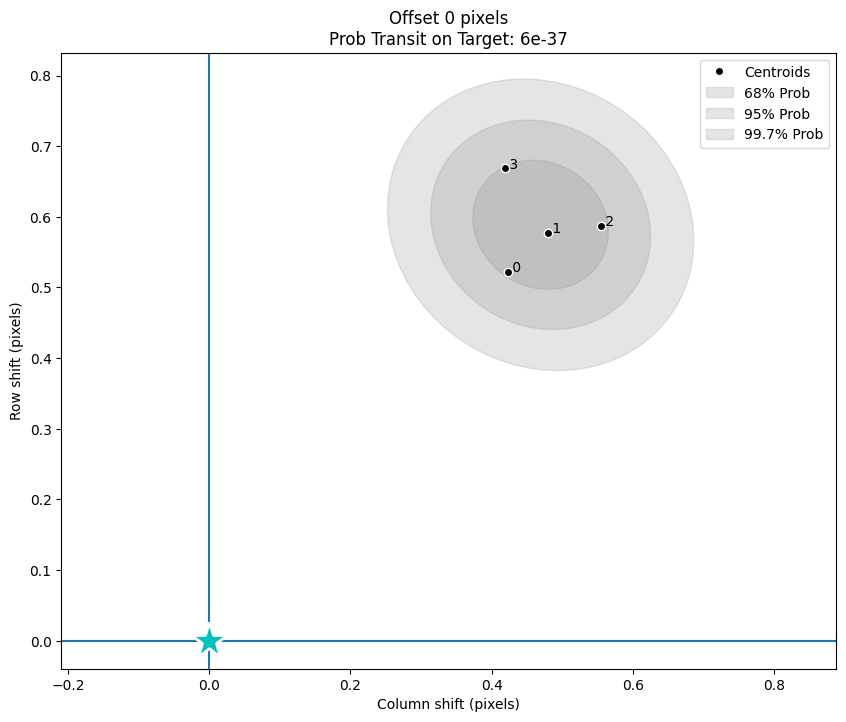

In [5]:
from astroquery.mast import Catalogs
from astropy.coordinates import SkyCoord, ICRS

def get_gaia_info(ticid):
    """
    For a TIC ID integer return the gaia catalog information from MAST.
    """
    tic_data = Catalogs.query_criteria(ID = ticid, catalog="TIC")
    coord = SkyCoord(ra=tic_data['ra'], dec=tic_data['dec'], unit=(u.degree, u.degree), frame='icrs')
    gaia_r = Catalogs.query_object("%f, %f"%(tic_data['ra'], tic_data['dec']), radius = .05, catalog="Gaia")
    row = gaia_r[gaia_r['source_id'] == tic_data["GAIA"]]

    return row

ticid = 1103432 # TIC ID for previous example TOI 565.01
gaia = get_gaia_info(ticid)
target_coord = SkyCoord(ra = gaia['ra'], dec = gaia['dec'], unit = (u.degree, u.degree), frame=ICRS) 

starloc_pix = tpf.wcs.world_to_pixel(target_coord)

# run the centroid vetter with this tce and tpf
centroid_instance = vet.Centroid(starloc_pix=starloc_pix)
centroid_results = centroid_instance.run(tce, tpf, plot=True)
centroid_results